In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [52]:
import os
import io
import torch
from IPython.display import display, HTML
from graphviz import Digraph
from graphviz import Source
from torchvision import models
from PIL import Image
import base64
from io import BytesIO
from onnx.tools.net_drawer import GetPydotGraph
from torchviz import make_dot

from collections import defaultdict
import json
from onnx import ModelProto, GraphProto, NodeProto
import pydot


---------------------------

<class 'graphviz.dot.Digraph'>


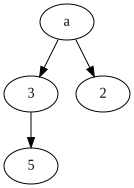

In [94]:
dot = Digraph()
# Add nodes
dot.node('1', label='a')
dot.node('3')
dot.node('2')
dot.node('5')

# Add edges
dot.edges(['12', '13', '35'])

# Visualize the graph
print(type(dot))
dot

In [95]:
data = dot._repr_svg_()
data = ''.join(data.split('\n')[6:])
print(len(data))
data

2201


'<svg width="134pt" height="188pt" viewBox="0.00 0.00 134.00 188.00" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"><g id="graph0" class="graph" transform="scale(1 1) rotate(0) translate(4 184)"><title>%3</title><polygon fill="#ffffff" stroke="transparent" points="-4,4 -4,-184 130,-184 130,4 -4,4"/><!-- 1 --><g id="node1" class="node"><title>1</title><ellipse fill="none" stroke="#000000" cx="63" cy="-162" rx="27" ry="18"/><text text-anchor="middle" x="63" y="-158.3" font-family="Times,serif" font-size="14.00" fill="#000000">a</text></g><!-- 3 --><g id="node2" class="node"><title>3</title><ellipse fill="none" stroke="#000000" cx="27" cy="-90" rx="27" ry="18"/><text text-anchor="middle" x="27" y="-86.3" font-family="Times,serif" font-size="14.00" fill="#000000">3</text></g><!-- 1&#45;&gt;3 --><g id="edge2" class="edge"><title>1&#45;&gt;3</title><path fill="none" stroke="#000000" d="M54.2854,-144.5708C50.0403,-136.0807 44.8464,-125.6929 40.1337,-116.2674"/><

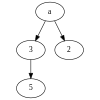

In [101]:
import cairosvg
png = BytesIO()
cairosvg.svg2png(bytestring=data, write_to=png, output_width=100, output_height=100)
Image.open(png)

In [66]:
# https://yoksel.github.io/url-encoder/ru/
# display(HTML('<img src="data:image/svg+xml;utf8,{}"/>'.format(svg_url_encoder_data)))

In [ ]:
OP_STYLE = {
    'shape': 'box',
    'color': '#0F9D58',
    'style': 'filled',
    'fontcolor': '#FFFFFF'
}

BLOB_STYLE = {'shape': 'octagon'}


def _escape_label(name):
    return json.dumps(name)

def XGetOpNodeProducer(**kwargs):
    def ReallyGetOpNode(op, op_id):
        if op.name:
            node_name = '%s/%s (op#%d)' % (op.name, op.op_type, op_id)
        else:
            node_name = '%s (op#%d)' % (op.op_type, op_id)
        for i, input in enumerate(op.input):
            node_name += '\n input' + str(i) + ' ' + input
        for i, output in enumerate(op.output):
            node_name += '\n output' + str(i) + ' ' + output
        return pydot.Node(node_name, **kwargs)
    return ReallyGetOpNode


def XGetPydotGraph(
    graph,
    name=None,
    rankdir='LR',
    node_producer=None,
):
    if node_producer is None:
        node_producer = XGetOpNodeProducer(**OP_STYLE)
    pydot_graph = pydot.Dot(name, rankdir=rankdir)
    pydot_nodes = {}
    pydot_node_counts = defaultdict(int)
    for op_id, op in enumerate(graph.node):
        op_node = node_producer(op, op_id)
        pydot_graph.add_node(op_node)
        for input_name in op.input:
            if input_name not in pydot_nodes:
                input_node = pydot.Node(
                    _escape_label(
                        input_name + str(pydot_node_counts[input_name])),
                    label=_escape_label(input_name),
                    **BLOB_STYLE
                )
                pydot_nodes[input_name] = input_node
            else:
                input_node = pydot_nodes[input_name]
            pydot_graph.add_node(input_node)
            pydot_graph.add_edge(pydot.Edge(input_node, op_node))
        for output_name in op.output:
            if output_name in pydot_nodes:
                pydot_node_counts[output_name] += 1
            output_node = pydot.Node(
                _escape_label(
                    output_name + str(pydot_node_counts[output_name])),
                label=_escape_label(output_name),
                **BLOB_STYLE
            )
            pydot_nodes[output_name] = output_node
            pydot_graph.add_node(output_node)
            pydot_graph.add_edge(pydot.Edge(op_node, output_node))
    return pydot_graph

In [49]:
model = torch.nn.Sequential()
model.add_module('W0', torch.nn.Linear(8, 16))
model.add_module('tanh', torch.nn.Tanh())
model.add_module('W1', torch.nn.Linear(16, 1))

print(type(model), isinstance(model, torch.nn.Module))

x = torch.randn(1,8)
fp = io.BytesIO()

torch.onnx.export(
    model,
    x,
    fp,
    verbose=True,
    export_params=True)

<class 'torch.nn.modules.container.Sequential'> True
graph(%input.1 : Float(1, 8),
      %W0.weight : Float(16, 8),
      %W0.bias : Float(16),
      %W1.weight : Float(1, 16),
      %W1.bias : Float(1)):
  %5 : Float(1, 16) = onnx::Gemm[alpha=1, beta=1, transB=1](%input.1, %W0.weight, %W0.bias) # /usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1370:0
  %6 : Float(1, 16) = onnx::Tanh(%5) # /usr/local/lib/python3.6/dist-packages/torch/nn/modules/activation.py:295:0
  %7 : Float(1, 1) = onnx::Gemm[alpha=1, beta=1, transB=1](%6, %W1.weight, %W1.bias) # /usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1370:0
  return (%7)



torch-jit-export
<class 'pydot.Dot'>
digraph "torch-jit-export" {
rankdir=TB;
"Gemm (op#0)\n input0 input.1\n input1 W0.weight\n input2 W0.bias\n output0 5" [color="#0F9D58", fontcolor="#FFFFFF", shape=box, style=filled];
"input.10" [label="input.1", shape=octagon];
"input.10" -> "Gemm (op#0)\n input0 input.1\n input1 W0.weight\n input2 W0.bias\n output0 5";
"W0.weight0" [label="W0.weight", shape=octagon];
"W0.weight0" -> "Gemm (op#0)\n input0 input.1\n input1 W0.weight\n input2 W0.bias\n output0 5";
"W0.bias0" [label="W0.bias", shape=octagon];
"W0.bias0" -> "Gemm (op#0)\n input0 input.1\n input1 W0.weight\n input2 W0.bias\n output0 5";
"Gemm (op#0)\n input0 input.1\n input1 W0.weight\n input2 W0.bias\n output0 5" -> "50";
"Tanh (op#1)\n input0 5\n output0 6" [color="#0F9D58", fontcolor="#FFFFFF", shape=box, style=filled];
"50" [label="5", shape=octagon];
"50" [label="5", shape=octagon];
"50" -> "Tanh (op#1)\n input0 5\n output0 6";
"Tanh (op#1)\n input0 5\n output0 6" -> "60";
"Gemm (

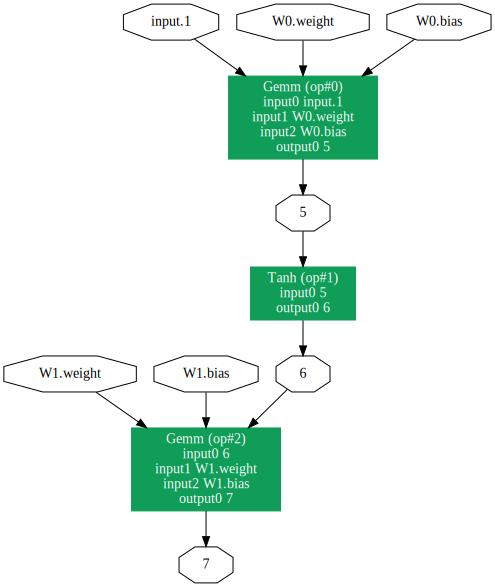

In [53]:
fp.seek(0)

model_proto = ModelProto()
model_proto.ParseFromString(fp.read())
pydot_graph = GetPydotGraph(
    model_proto.graph,
    name=model_proto.graph.name,
    rankdir='TB'
)

print(model_proto.graph.name)
print(type(pydot_graph))
print(pydot_graph.to_string())
print(model)

dot = Source(pydot_graph.to_string(), format="png")
dot

In [ ]:
Image.open(BytesIO(pydot_graph.create_png()))
type(BytesIO(pydot_graph.create_png()).getvalue())

In [54]:
alexnet_model = models.alexnet()
alexnet_input = torch.randn((1, 3, 224, 224))

9826


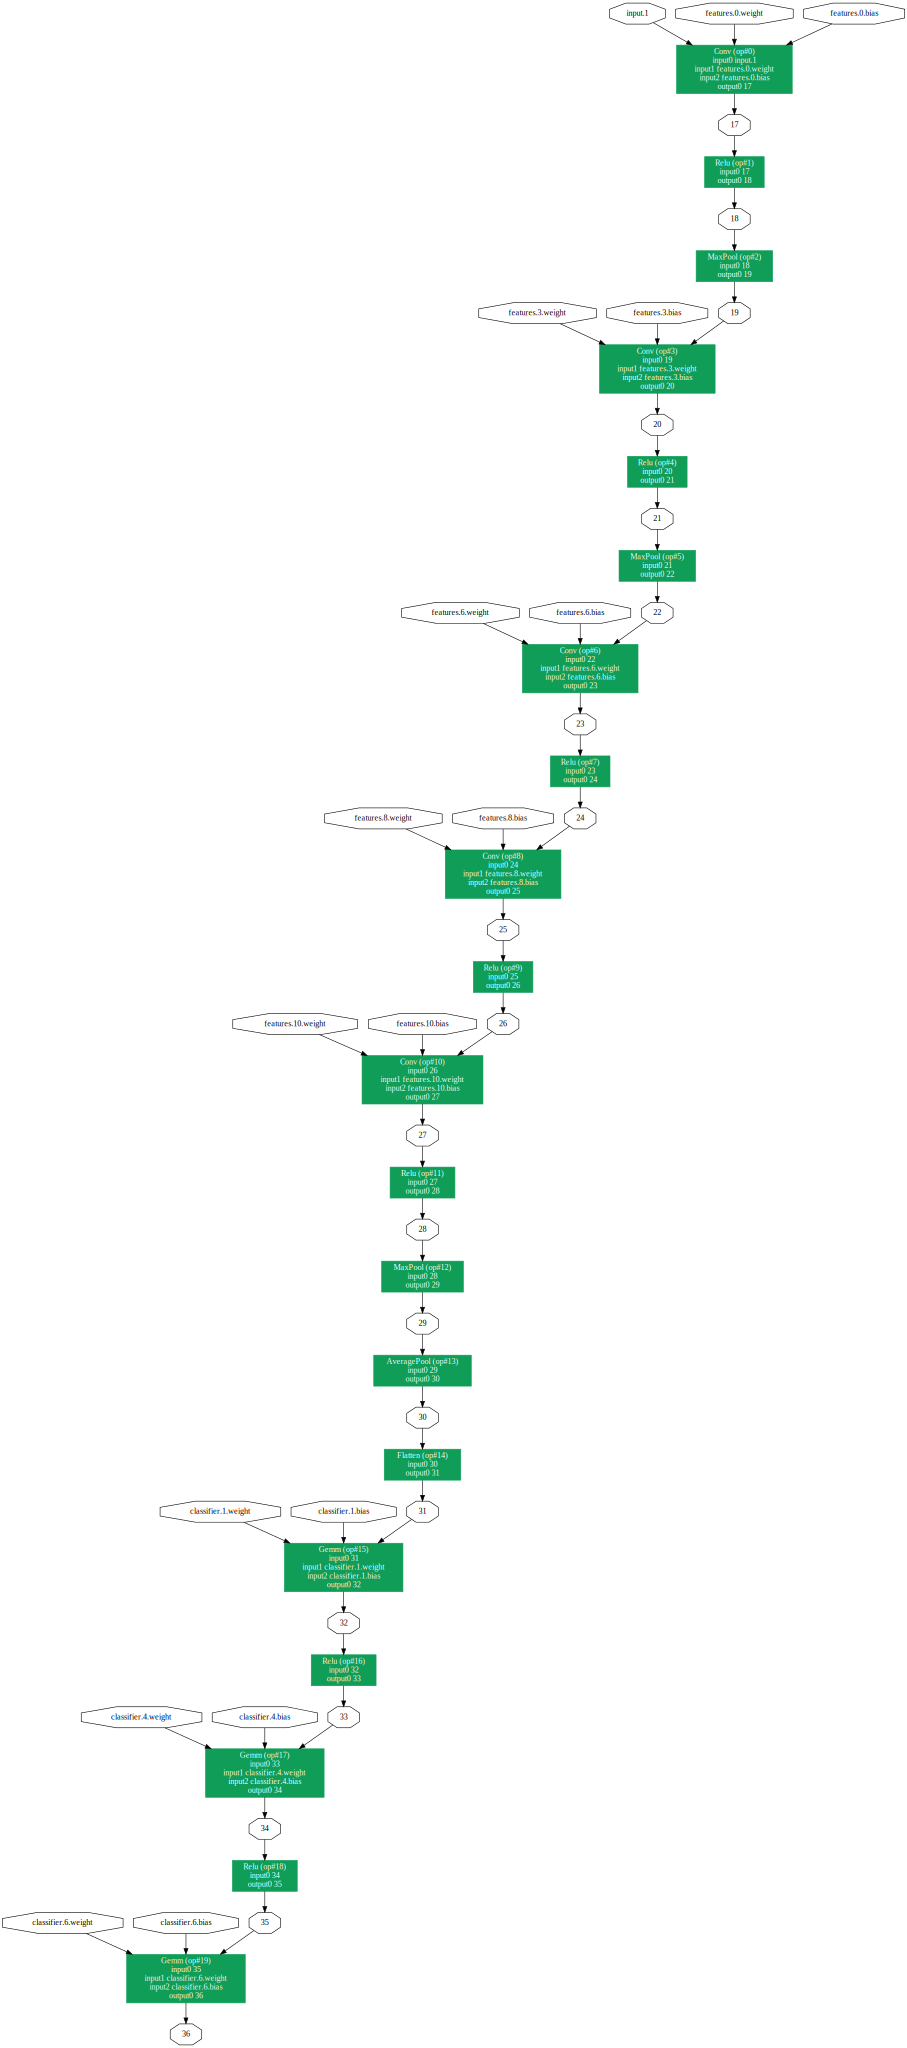

In [55]:
alexnet_onnx_fp = io.BytesIO()

torch_out = torch.onnx.export(
    alexnet_model,
    alexnet_input,
    alexnet_onnx_fp,
    export_params=True)

alexnet_onnx_fp.seek(0)

alexnet_model_proto = ModelProto()
alexnet_model_proto.ParseFromString(alexnet_onnx_fp.read())
alexnet_pydot_graph = GetPydotGraph(
    alexnet_model_proto.graph,
    name=alexnet_model_proto.graph.name,
    rankdir='TB'
)

print(len(alexnet_pydot_graph.to_string()))

dot = Source(alexnet_pydot_graph.to_string(), format="png")
dot

In [ ]:
Image.open(BytesIO(alexnet_pydot_graph.create_png()))

In [56]:
model_graph = alexnet_pydot_graph

model_graph.write_png('/data/alexnet_pydot_graph.png')
!ls -lh /data/alexnet_pydot_graph.png

model_graph.write_svg('/data/alexnet_pydot_graph.svg')
!ls -lh /data/alexnet_pydot_graph.svg

model_graph.write_svgz('/data/alexnet_pydot_graph.svgz')
!ls -lh /data/alexnet_pydot_graph.svgz

-rw-rw-rw- 1 root root 362K Apr 23 15:39 /data/alexnet_pydot_graph.png
-rw-rw-rw- 1 root root 58K Apr 23 15:39 /data/alexnet_pydot_graph.svg
-rw-rw-rw- 1 root root 8.3K Apr 23 15:39 /data/alexnet_pydot_graph.svgz


b64str_png:492892



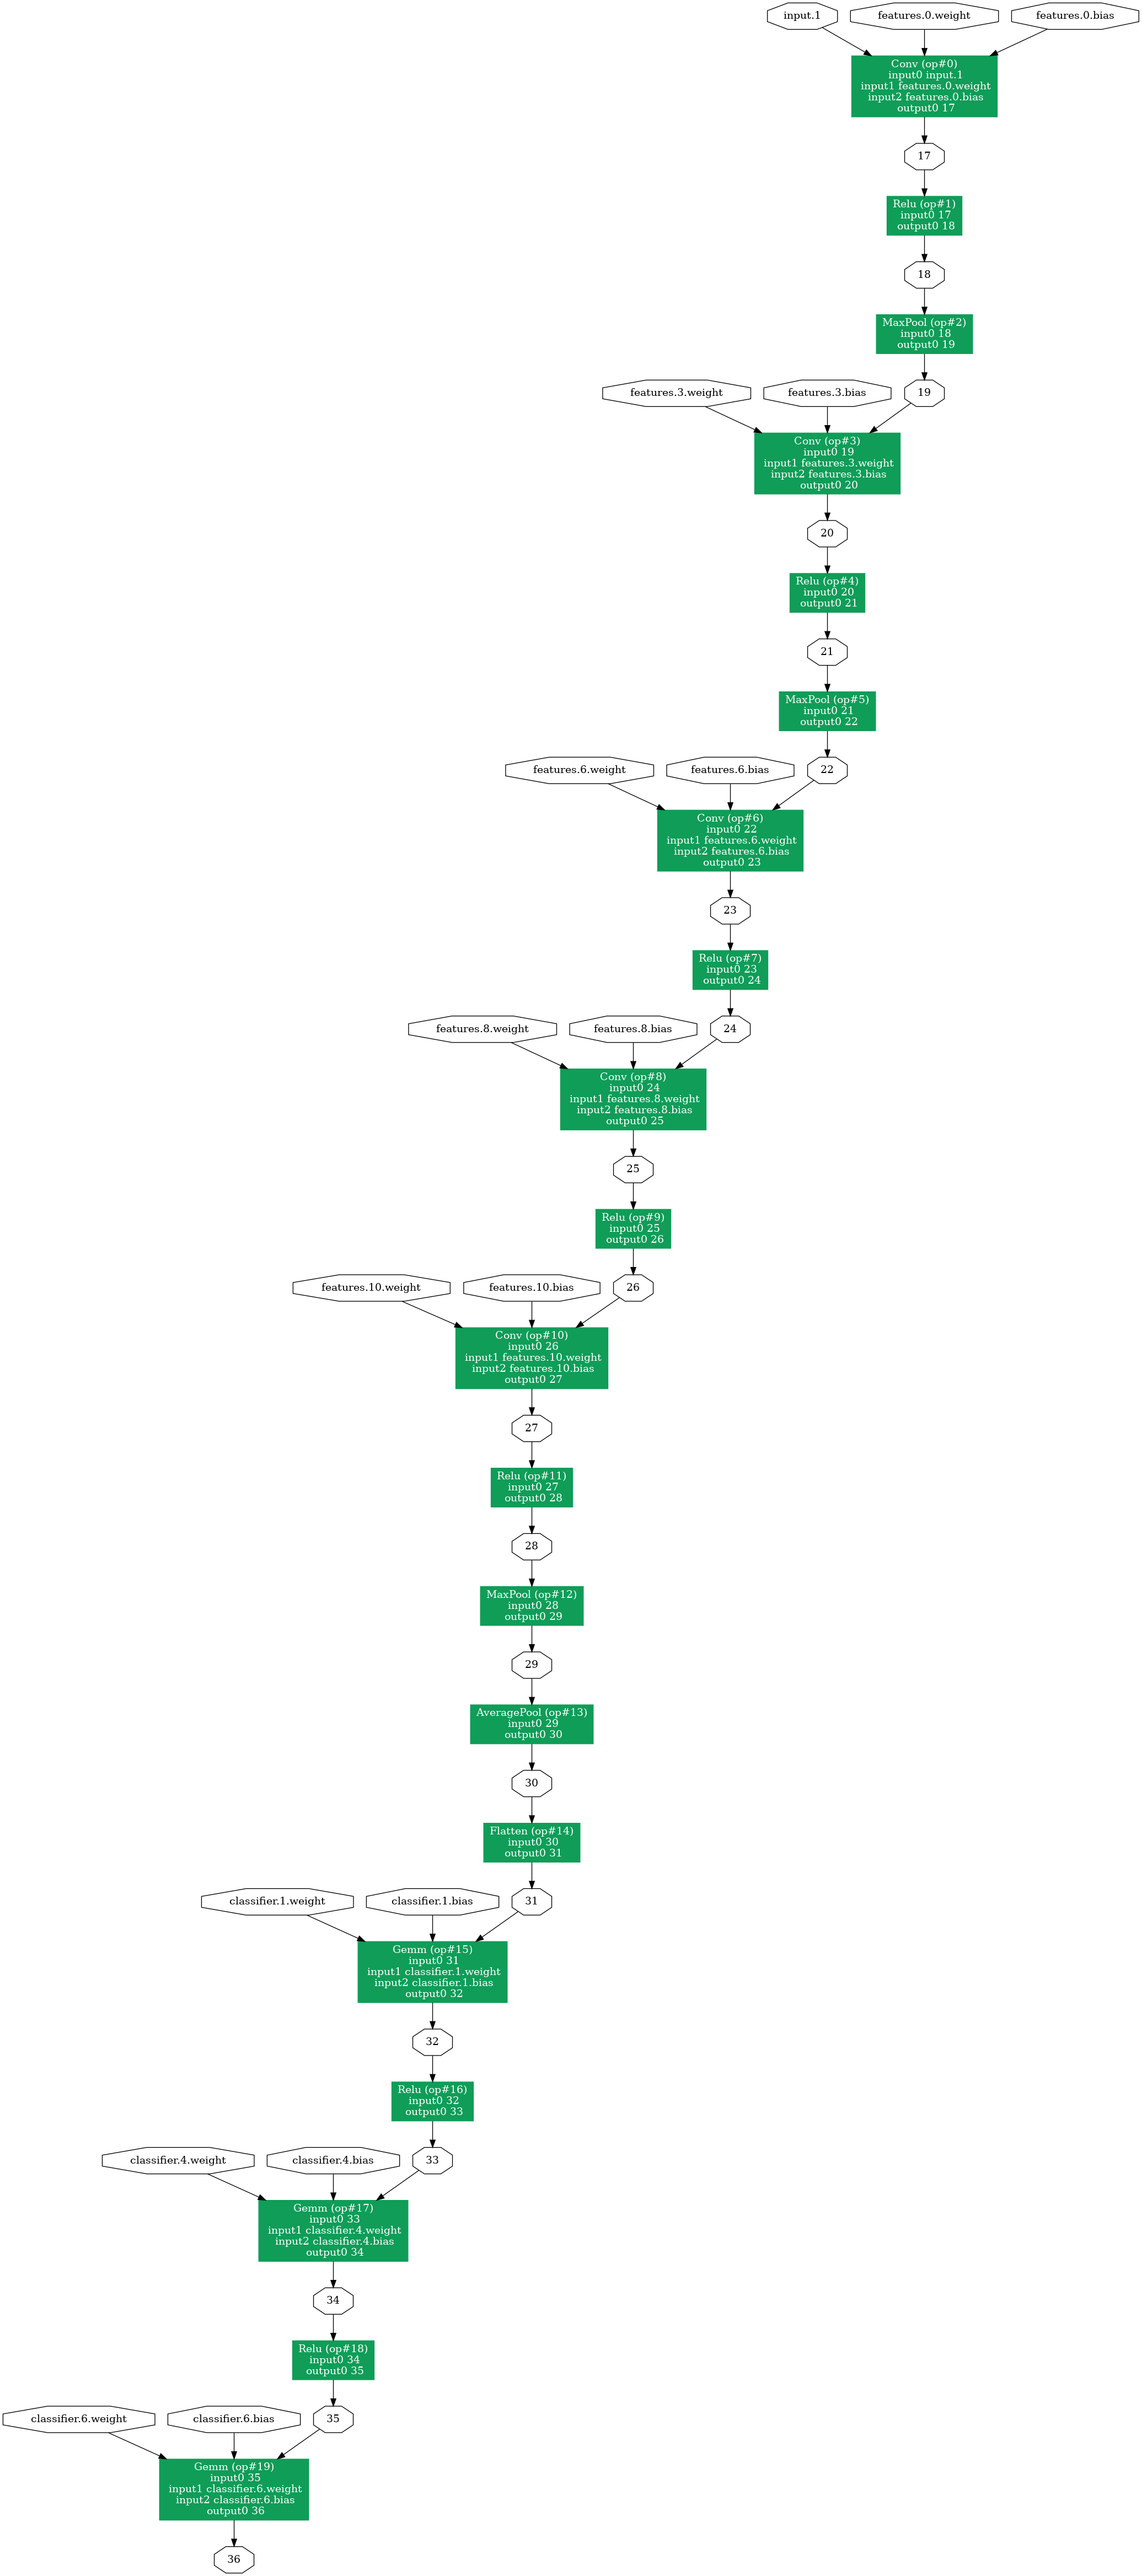

In [71]:
b64str_png = base64.b64encode(model_graph.create_png()).decode()
print("b64str_png:%d" % len(b64str_png))
display(HTML('''<img src="data:image/png;base64,{}"/>'''.format(b64str_png)))

In [70]:
svg_b = model_graph.create_svg()
svg = svg_b.decode()
print(len(svg_b))
svg = ''.join(svg.split('\n')[6:])
print(len(svg))
b64str_svg = base64.b64encode(svg_b).decode()
print("b64str_svgz: %d vs %d" % (len(svg), len(b64str_svg)))
# display(HTML('''<img src="data:image/svg+xml;base64,{}"/>'''.format(b64str_svg)))
HTML(svg)

59215
58206
b64str_svgz: 58206 vs 78956


In [ ]:
# fail
svgz = model_graph.create_svgz()
b64str_svgz = base64.b64encode(svgz).decode()
print("b64str_svgz: %d %d" % (len(svgz), len(b64str_svgz)))
display(HTML('''<img src="data:image/svg+xml;base64,{}"/>'''.format(b64str_svgz)))
# print(b64str_svgz)

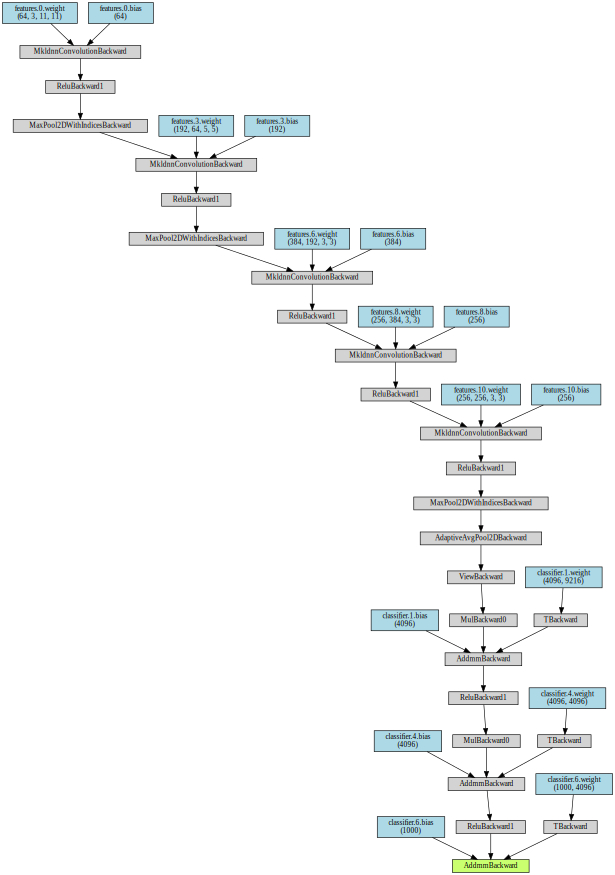

In [85]:
dot = make_dot(alexnet_model(alexnet_input), params=dict(alexnet_model.named_parameters()))
# dot = dot.pipe(format='svg').decode()
# dot.split('\n')[6:]
dot

-----------------

<class 'bytes'>
<class 'graphviz.dot.Digraph'>


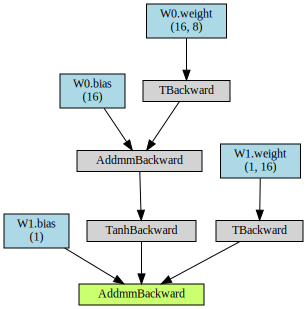

In [78]:
dot = make_dot(model(x), params=dict(model.named_parameters()))
print(type(dot.pipe(format='png')))
print(type(dot))
dot
# with torch.onnx.set_training(model, False):
#     try:
#         trace = torch.jit.trace(model, x)
#         graph = trace.graph
#         torch._C._jit_pass_inline(graph)
#     except RuntimeError as e:
#         print(e)
#         print('Error occurs, No graph saved')
#         raise e
#     
# for n in graph.nodes():
#     print(dir(n), n.kind())
#     for i in n.inputs():
#         print(i.node)
#         print(dir(i))
#         break
#     break